In [53]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

#from preprocessing.encoding_pipeline import processing_pipe

import sys  
sys.path.insert(0, '../preprocessing')

import encoding_pipeline
from encoding_pipeline import processing_pipe

from sklearn.model_selection import train_test_split,cross_validate,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importing and preprocessing clean data


In [34]:
clean_data = gpd.read_file("../raw_data/project_data_clean.shp")

In [47]:
X_clean = clean_data.drop(columns=['green_roof', 'geometry'])

X = pd.DataFrame(processing_pipe(X_clean))
y = clean_data['green_roof']

In [48]:
#split into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Models

### DummyModel / Baseline

In [49]:
baseline_model = DummyClassifier(strategy="most_frequent") 
baseline_model.fit(X_train, y_train) 
baseline_model.score(X_test, y_test) 

0.9728029602220166

### Models to crossvalidate

In [50]:
# Initialze the estimators
RandomForest = RandomForestClassifier(random_state=42)
SVC_ = SVC(probability=True, random_state=42)
LogReg = LogisticRegression(max_iter=1000, random_state=42)
DecTree = DecisionTreeClassifier(max_depth=10, random_state=42)
KNeigh = KNeighborsClassifier()
GradBoost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=3, random_state=42)

### Crossvalidation and visualisation of scores

RandomForestClassifier(random_state=42) done


/Users/margauxhuth/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/margauxhuth/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/margauxhuth/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

SVC(probability=True, random_state=42) done
LogisticRegression(max_iter=1000, random_state=42) done
DecisionTreeClassifier(max_depth=10, random_state=42) done
KNeighborsClassifier() done
GradientBoostingClassifier(random_state=42) done


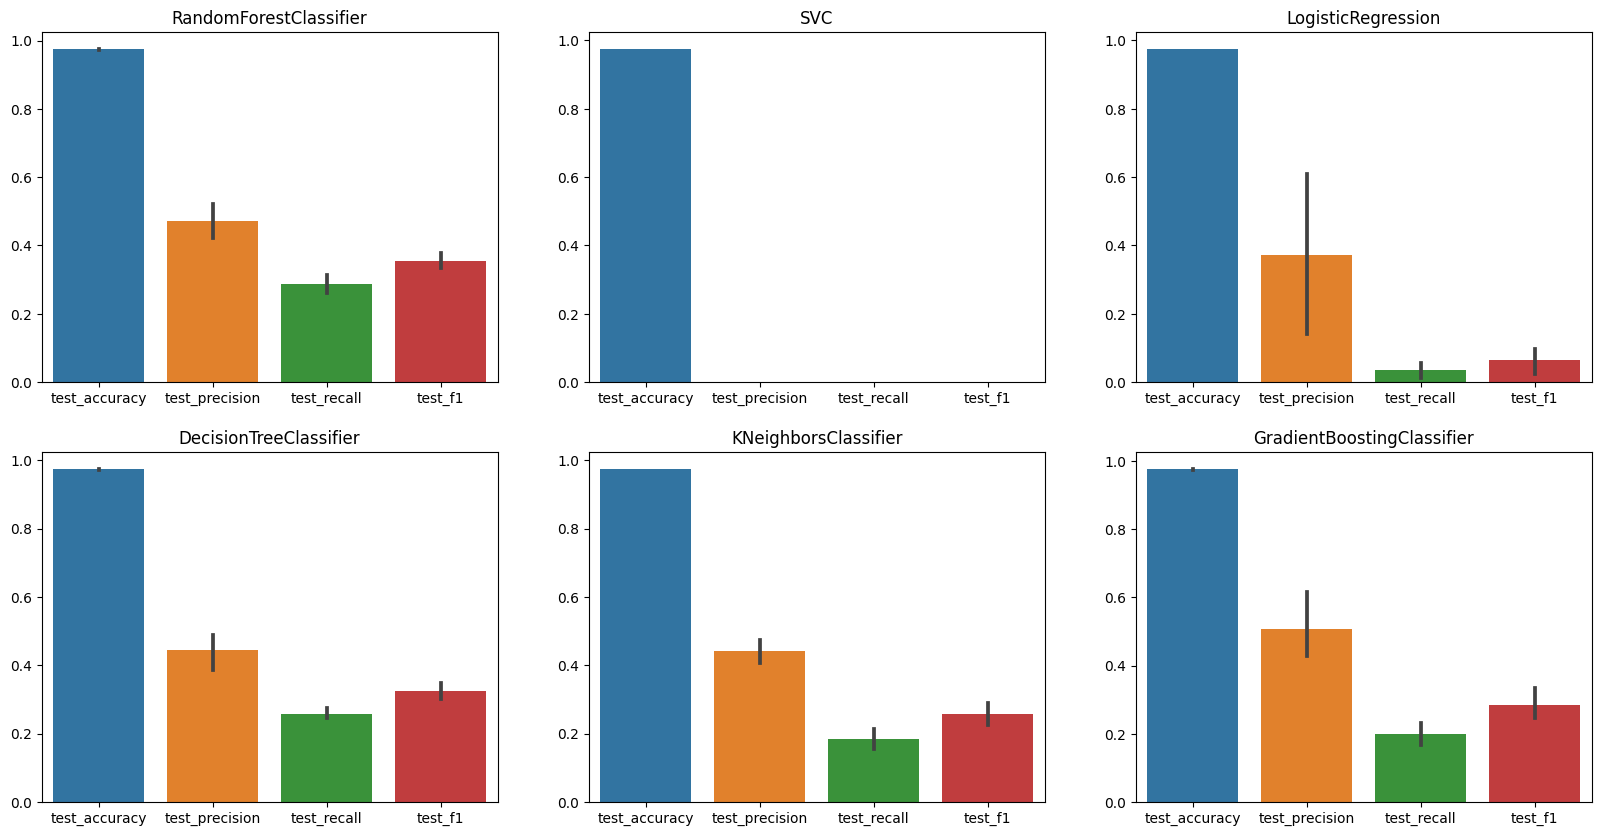

In [51]:
spots = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
list_models = [RandomForest, SVC_, LogReg,DecTree, KNeigh,GradBoost]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

results_all = {}

for idx, model in zip(spots, list_models):
    results = cross_validate(model, X_train, y_train, cv = 5,scoring = ['accuracy','precision','recall','f1'])
    d = {f"{model}".split('(')[0] : pd.DataFrame(results).drop(columns=['fit_time','score_time'])}
    results_all[f"{model}".split('(')[0]] = results
    print(f'{model} done')

    sns.barplot(data=d[f"{model}".split('(')[0]],ax=axes[idx[0],idx[1]]).set(title=f"{model}".split('(')[0])

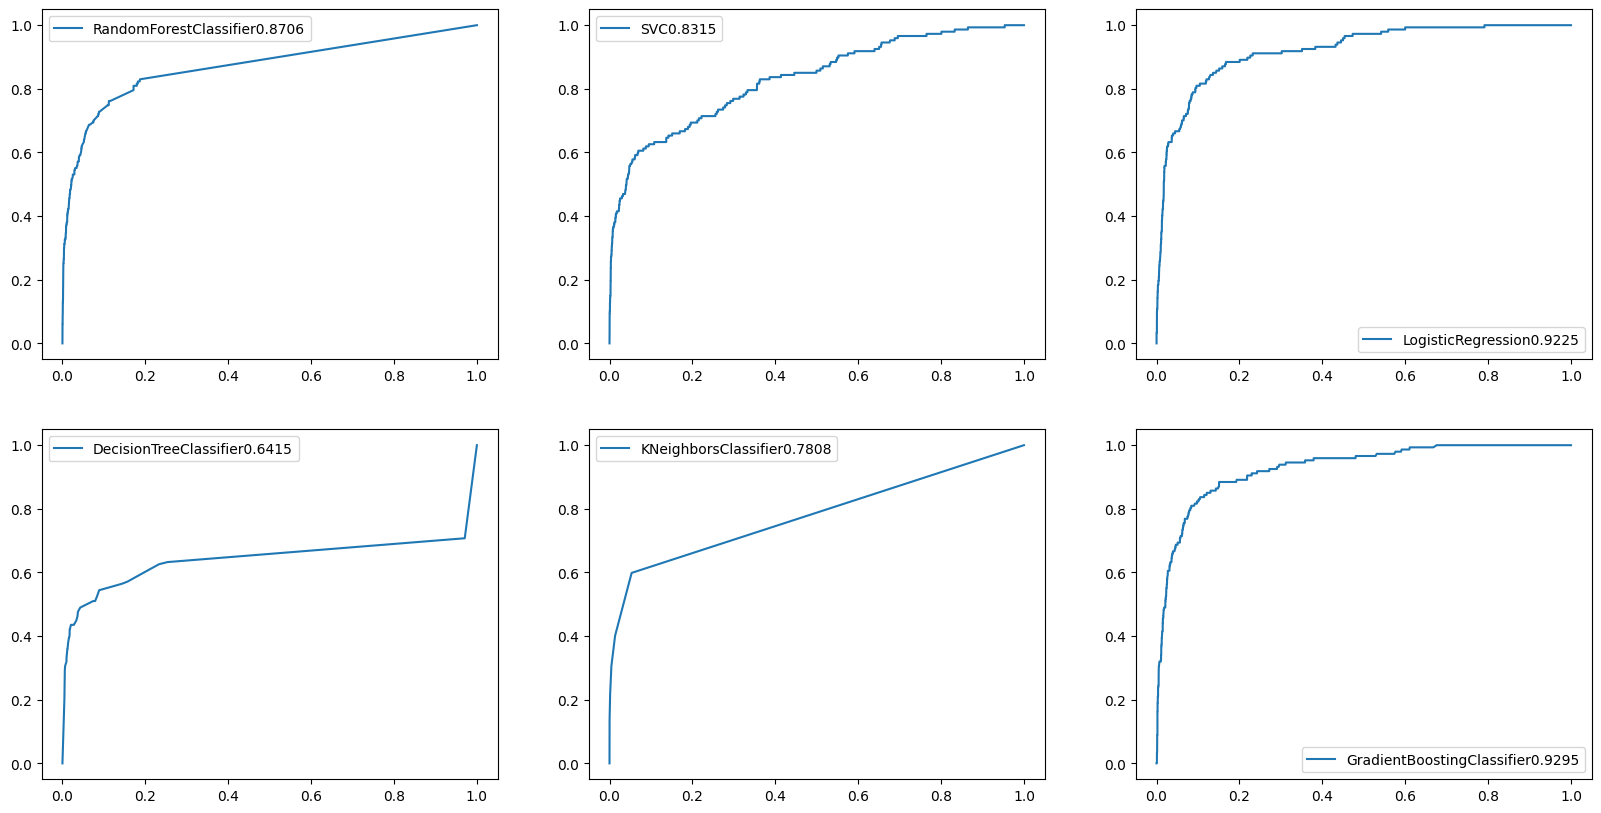

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for idx, model in zip(spots, list_models):
    model.fit(X_train,y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
    
    axs[idx[0],idx[1]].plot(fpr,tpr,label=f"{model}".split('(')[0] + str(auc))
    axs[idx[0],idx[1]].legend()

## Grid Search CV: 

In [56]:
%%time

params = {}
params['n_estimators'] = [10, 50, 100, 250]
params['max_depth'] = [5, 10, 20]

# Train the grid search model
gs = GridSearchCV(GradBoost, params, cv=3, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)

CPU times: user 1.12 s, sys: 92.7 ms, total: 1.21 s
Wall time: 27.5 s


In [60]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 50}